<img src="https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/15b4b6b851f9044910f7912d9d3d0282421a3f11/sesiones/sesion11/resources/BANNER_SESIONSEMILLERO.png" width="1000" align="middle"/>


# <font color='#fabf61'>**Hands-On Sesión 11: Natural Language Processing 🔤🤖💬**</font>   
## <font>**Tabla de Contenidos**</font>
1. LLMs 🤖
  - Preprocesamiento del texto
  - Tokenizer
  - GPT-2 arquitecture
2. Algunas tareas de NLP 💻🥸
  - Named Entity Recognition
  - Summarization
  - Automatic Speech Recognition
  - Text to Speech

In [2]:
#@title instalamos librerías
!pip install bertviz
!python -m spacy download es_core_news_lg #Modelos disponibles: sm o md o lg
!pip install openai-whisper --no-deps
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#@title importamos librerías

# utils
import os
import re
from collections import Counter
import pandas as pd
import numpy as np
from visualization import TokenVisualization

# nlp trad
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
#from gensim.models import Word2Vec
import spacy
from spacy.tokens import Span
from spacy import displacy

# visualize
from IPython.display import display, HTML, Image, Audio
from tabulate import tabulate
from graphviz import Digraph

from bertviz.neuron_view import show
from bertviz import head_view
from bertviz.transformers_neuron_view import GPT2Model, GPT2Tokenizer

# transformers, llms, whisper, metrics
import torch
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM,
    pipeline,
    logging,
    utils
)
from transformers.generation import GenerationConfig
import whisper
from datasets import load_metric



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## <font color='#FC9797'>**LLMs 🤖**</font>
Antes de la llegada de los LLMs, los métodos tradicionales destacaban en tareas de categorización como la clasificación de correo no deseado y el reconocimiento directo de patrones, que podían capturarse con reglas personalizadas o modelos más simples. Sin embargo, solían tener un rendimiento inferior en tareas lingüísticas que exigían capacidades complejas de comprensión y generación, como el análisis sintáctico de instrucciones detalladas, el análisis contextual y la creación de textos originales coherentes y contextualizados.

El éxito de los LLM se puede atribuir a la arquitectura del **transformer** en la que se apoyan muchos LLMs, y a la gran cantidad de datos con los que se entrenan, lo que les permite capturar una amplia variedad de matices, contextos y patrones lingüísticos que serían difíciles de codificar manualmente.

### <font color='#EC91CE'>**Tokenizar y preprocesar texto**</font>
La tokenización es el proceso de convertir texto en una secuencia de tokens, que pueden ser palabras, subpalabras o caracteres. Estos tokens son las unidades de significado más pequeñas de un texto que un modelo de lenguaje puede procesar. Este proceso simplifica el texto y ayuda al modelo trabajar con bloques de datos más manejables.

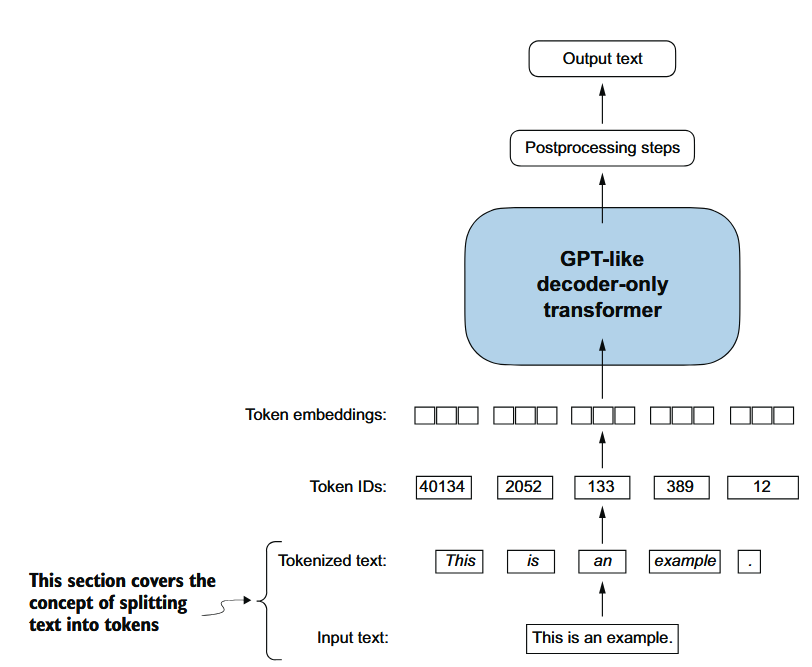

In [4]:
#@title pipeline
from IPython.display import Image
Image('/content/tokenizer.png', width=700)


In [5]:
#cargamos uno de los .txt
with open("/content/betty.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()
print("Total de caracteres:", len(raw_text))
print("300 primeros caracteres:",raw_text[:300])

Total de caracteres: 14152
300 primeros caracteres: 
Armando lee la carta que Mario escribió. Mario narra:

Mario Calderón: Mi estimado presidente, aquí están las instrucciones para que continúe su rutina de horror con Betty.
En primera instancia, encontrará las tarjetas que deberá continuar colocándole en el escritorio cada mañana a su monstruito, c


#### Naive approach
Dividir cada palabra y carácter especial en tokens distintos y asignarles un token ID. Para ello construimos un vocabulario, el cual definirá como mapearemos cada palabra y carácter único.

In [6]:
def limpiar_texto(texto):
    texto = texto.lower() #pasar a minúsculas
    texto = re.sub(r'[\n\t\r]', ' ', texto) #eliminar saltos de línea, tabs etc
    texto = ''.join(c for c in texto if c.isprintable()) #eliminar caracteres no imprimibles
    tokens = re.findall(r'\w+|[¿¡,.:;?_!"()\[\]\'\-\—]', texto) #tokenizar por palabra y signo de puntuación
    return tokens

In [7]:
preprocessed = limpiar_texto(raw_text)
print('100 primeros tokens:', (preprocessed[:99]))
print('Cantidad de tokens:', len(preprocessed))
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print('Tamaño de nuestro vocabulario:', vocab_size)

100 primeros tokens: ['armando', 'lee', 'la', 'carta', 'que', 'mario', 'escribió', '.', 'mario', 'narra', ':', 'mario', 'calderón', ':', 'mi', 'estimado', 'presidente', ',', 'aquí', 'están', 'las', 'instrucciones', 'para', 'que', 'continúe', 'su', 'rutina', 'de', 'horror', 'con', 'betty', '.', 'en', 'primera', 'instancia', ',', 'encontrará', 'las', 'tarjetas', 'que', 'deberá', 'continuar', 'colocándole', 'en', 'el', 'escritorio', 'cada', 'mañana', 'a', 'su', 'monstruito', ',', 'con', 'su', 'respectivo', 'detalle', '.', 'no', 'se', 'le', 'vaya', 'a', 'olvidar', 'porque', 'yo', 'no', 'voy', 'a', 'estar', 'para', 'hacerlo', '.', '(', 'sigue', 'la', 'música', 'de', 'tensión', ')', 'don', 'roberto', 'mendoza', ':', 'un', 'momento', '.', '.', '.', '[', 'nervioso', 'y', 'confundido', ']', '¿', 'qué', 'significa', 'esta', 'primera', 'página']
Cantidad de tokens: 3007
Tamaño de nuestro vocabulario: 687


In [9]:
vocab = {token:integer for integer,token in enumerate(all_words)}
print('20 primeros tokens únicos junto a sus respectivos IDs:')
for i, item in enumerate(vocab.items()):
  print(item)
  if i >= 20:
    break

20 primeros tokens únicos junto a sus respectivos IDs:
('!', 0)
('(', 1)
(')', 2)
(',', 3)
('-', 4)
('.', 5)
(':', 6)
('?', 7)
('[', 8)
(']', 9)
('a', 10)
('abono', 11)
('acabamos', 12)
('acabaron', 13)
('acabó', 14)
('acordarme', 15)
('activos', 16)
('acá', 17)
('además', 18)
('admitir', 19)
('afortunadamente', 20)


In [10]:
#@title Clase para codificar texto en tokens y decodificar tokens en texto
class SimpleTokenizerV1:
  def __init__(self, vocab):
    self.str_to_int = vocab
    self.int_to_str = {i:s for s,i in vocab.items()}
  def encode(self, text):
    preprocessed = limpiar_texto(text)
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids
  def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids])
    text = re.sub(r'\s+([,.?!"()\'\-])', r'\1', text)
    return text

In [11]:
tokenizer = SimpleTokenizerV1(vocab)

# puedes cambiar múltiples parámetros para modificar el visualizer!
token_viz = TokenVisualization(
    encoder=tokenizer.encode,
    decoder=tokenizer.decode,
    font_family='Arial',
)

# definimos un fragmento del texto original para visualizar sus tokens
tokens = tokenizer.encode(raw_text) # codificar texto en token IDs
fragmento_tokens = tokens[600:670] # escoger un fragmento de estos tokens
sample_text = tokenizer.decode(fragmento_tokens) # decodificar estos tokens en texto

html = token_viz.visualize(sample_text)
HTML(html)


In [13]:
#@title RETO: Qué ocurre si pasamos palabras no presentes en el texto original?
texto = 'Hugo Andrade es profesor de la UIS' # @param {type:"string"}
html = token_viz.visualize(texto)
HTML(html)


KeyError: 'andrade'

**↑↑↑↑ Por qué ocurre esto?**

In [14]:
# modificamos el vocabulario para incluir 2 nuevos tokens
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print('Tamaño del vocabulario: ',len(vocab.items())) # el tamaño de nuestro vocabulario subió!
print('Últimos 5 tokens')
for i, item in enumerate(list(vocab.items())[-5:]):
  print(item)

Tamaño del vocabulario:  689
Últimos 5 tokens
('única', 684)
('únicamente', 685)
('—', 686)
('<|endoftext|>', 687)
('<|unk|>', 688)


In [15]:
#@title Modificamos clase tokenizer para manejar estos tokens especiales
def limpiar_texto(texto):
    texto = texto.lower() #pasar a minúsculas
    texto = re.sub(r'[\n\r\t]', ' ', texto)
    texto = ''.join(c for c in texto if c.isprintable())
    # primero identifica tokens como <|endoftext|>, luego palabras y signos
    tokens = re.findall(r'<\|.*?\|>|\w+|[¿¡,.:;?_!"()\[\]\'\-\—]', texto)
    return tokens

class SimpleTokenizerV2:
  def __init__(self, vocab):
    self.str_to_int = vocab
    self.int_to_str = {i:s for s,i in vocab.items()}
    self.unk_token = "<|unk|>" #acá!

  def encode(self, text):
    preprocessed = limpiar_texto(text)
    preprocessed = [token if token in self.str_to_int else self.str_to_int for token in preprocessed] # reemplaza palabras desconocidas con <|unk|>
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids
  def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids])
    text = re.sub(r'\s+([¿¡,.?!"()\'\-])', r'\1', text)
    return text

In [16]:
tokenizer = SimpleTokenizerV2(vocab)
token_viz = TokenVisualization(
    encoder=tokenizer.encode,
    decoder=tokenizer.decode,
    font_family='Arial',
    #cmap='tab10'
)

texto1 = 'hugo' # @param {type:"string"}
texto2 = "uis" # @param {type:"string"}
texto = "<|endoftext|>".join((texto1, texto2))

html = token_viz.visualize(texto)
HTML(html)

TypeError: unhashable type: 'dict'

#### Byte Pair Encoding (BPE)
BPE descompone las palabras que no están en su vocabulario predefinido en subpalabras más pequeñas o incluso en caracteres individuales, lo que le permite manejar palabras fuera del vocabulario. Así, gracias a este, si el tokenizador encuentra una palabra desconocida durante la tokenización, puede representarla como una secuencia de subpalabras o caracteres. Se denomina *Byte* por lo que se hace a nivel de bytes.

**Pasos**
1. Obtener el vocabulario inicial de tokens
2. Tokenizar el texto con estos tokens base
3. Contar pares de tokens consecutivos
4. Seleccionar el par de tokens más frecuente y crear un nuevo token que sea la combinación del par más frecuente
5. Repetir desde el paso 3 hasta alcanzar el número deseado de combinaciones o vocabulario



In [17]:
vocab_size = 93000 # número de palabras en la RAE
embedding_dim = 768  # dimensión de cada vector de embedding de GPT-2
bytes_per_float = 4  # 32 bits = 4 bytes por número flotante

total_bytes = vocab_size * embedding_dim * bytes_per_float
total_kb = total_bytes / 1024
total_mb = total_kb / 1024

print(f"Memoria requerida:")
print(f"- Bytes: {total_bytes:,}")
print(f"- KB: {total_kb:,.2f}")
print(f"- MB: {total_mb:,.2f}")


Memoria requerida:
- Bytes: 285,696,000
- KB: 279,000.00
- MB: 272.46


In [18]:
#@title Clase para manejar BPE
class BPE:
    def __init__(self):
        self.dictionary = {i: [i] for i in range(256)}

    def encode(self, text):
        return list(text.encode('utf-8'))  # convierte texto a lista de IDs de bytes

    def decode(self, ids):
        if isinstance(ids, int):
            if ids <= 255:
                # token base (byte), decodificar directamente
                return bytes([ids]).decode('utf-8', errors='replace')
            else:
                # token merge: buscar en diccionario y decodificar recursivamente
                if ids not in self.dictionary:
                    raise ValueError(f"Token {ids} no está en el diccionario")
                return self.decode(self.dictionary[ids])
        elif isinstance(ids, list):
            # si todos los elementos son bytes (ints entre 0 y 255), decodificarlos juntos
            if all(isinstance(i, int) and 0 <= i <= 255 for i in ids):
                return bytes(ids).decode('utf-8', errors='replace')
            else:
                # si hay tokens merge en la lista, decodificarlos recursivamente y concatenar
                return ''.join(self.decode(i) for i in ids)
        else:
            raise ValueError("Entrada inválida para decode")

    def merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) -1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        # guarda en el diccionario la concatenación de los bytes de ambos tokens que forman el merge
        self.dictionary[idx] = self.dictionary[pair[0]] + self.dictionary[pair[1]]
        return newids

    def decode_merges_dict(self,merges):
      #decodificar merges en caracteres
        decoded_dict = {}
        for pair, idx in merges.items():
            decoded_pair = tuple(self.decode(token) for token in pair)
            decoded_value = self.decode(idx)
            decoded_dict[decoded_pair] = decoded_value
        return decoded_dict

In [19]:
tokenizer = BPE()
sample_text='Pablito clavó un clavito en la calva de un calvito. Un clavito clavó Pablito en la calva de un calvito'

pre_proc = re.split(r'([¿¡,.:;?_!"()\'\-\—]|--|\s+)', sample_text)
pre_proc = [item.strip() for item in pre_proc if item.strip()]

tokens=tokenizer.encode(sample_text)

print('Cantidad de caracteres',len(pre_proc))
print('Cantidad de bytes/tokens',len(tokens)) # por qué son más que el número de caracteres?


Cantidad de caracteres 21
Cantidad de bytes/tokens 104


In [20]:
df = pd.DataFrame({
    'Byte ID': tokens,
    'Char': [bytes([b]).decode('utf-8', errors='replace') for b in tokens]
}) #este es nuestro vocabulario
df.head()

,Byte ID,Char
0,80,P
1,97,a
2,98,b
3,108,l
4,105,i


In [22]:
i=0
freqs = Counter(pre_proc)
top = freqs.most_common(20)
print(f"{'Palabra':<10} {'Frecuencia':>10}")
print("-" * 22)
for word, freq in top:
    if i>20:
      break
    print(f"{word:<10} {freq:>10}")
    i+=1

Palabra    Frecuencia
----------------------
un                  3
Pablito             2
clavó               2
clavito             2
en                  2
la                  2
calva               2
de                  2
calvito             2
.                   1
Un                  1


In [23]:
def get_stats(tokens):
    stats = {}
    for tok1, tok2 in zip(tokens, tokens[1:]):
        if (tok1, tok2) in stats:
            stats[(tok1, tok2)] += 1
        else:
            stats[(tok1, tok2)] = 1
    return stats

pairs=tokenizer.decode(tokens)
stats = get_stats(pairs)

i=0
print(f"{'Par':<10} {'Frecuencia':>10}")
print("-" * 22)
for pair, freq in stats.items():
    if i>15:
      break
    print(f"{pair} {freq:>10}")
    i+=1

Par        Frecuencia
----------------------
('P', 'a')          2
('a', 'b')          2
('b', 'l')          2
('l', 'i')          2
('i', 't')          6
('t', 'o')          6
('o', ' ')          4
(' ', 'c')          8
('c', 'l')          4
('l', 'a')          6
('a', 'v')          4
('v', 'ó')          2
('ó', ' ')          2
(' ', 'u')          3
('u', 'n')          3
('n', ' ')          6


In [25]:
#@title Hacer merge entre pares más usados
vocab_size_final = 276
vocab_size_original = 256
num_merges = vocab_size_final - vocab_size_original
ids = list(tokens) # copiamos para no destruir la lista original de tokens

merges = {}
for i in range(num_merges):
    stats = get_stats(tokens)
    top_pair = max(stats, key=stats.get)
    idx = vocab_size_original + i

    chars = tokenizer.decode(list(top_pair))
    print(f"merging {top_pair}('{chars}') into a new token {idx}")

    tokens = tokenizer.merge(tokens, top_pair, idx)
    merges[top_pair] = idx

merging (32, 99)(' c') into a new token 256
merging (105, 116)('it') into a new token 257
merging (257, 111)('ito') into a new token 258
merging (108, 97)('la') into a new token 259
merging (256, 259)(' cla') into a new token 260
merging (260, 118)(' clav') into a new token 261
merging (256, 97)(' ca') into a new token 262
merging (262, 108)(' cal') into a new token 263
merging (263, 118)(' calv') into a new token 264
merging (32, 117)(' u') into a new token 265
merging (265, 110)(' un') into a new token 266
merging (80, 97)('Pa') into a new token 267
merging (267, 98)('Pab') into a new token 268
merging (268, 108)('Pabl') into a new token 269
merging (269, 258)('Pablito') into a new token 270
merging (261, 195)(' clav�') into a new token 271
merging (271, 179)(' clav��') into a new token 272
merging (261, 258)(' clavito') into a new token 273
merging (32, 101)(' e') into a new token 274
merging (274, 110)(' en') into a new token 275


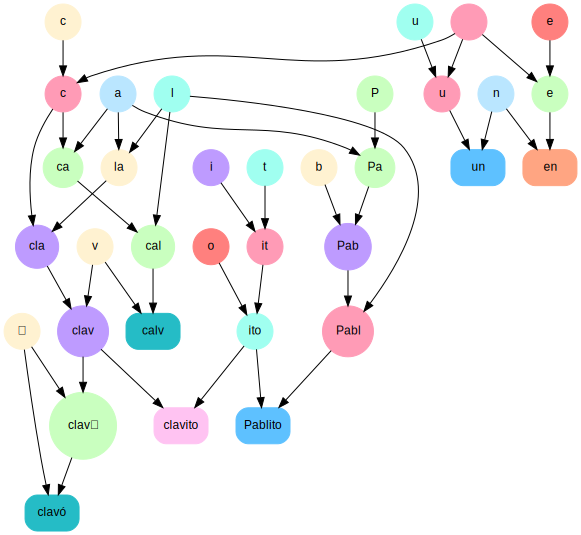

In [26]:
#@title Visualizar merges
def visualize_merges_graphviz(merges):
    dot = Digraph()
    dot.attr(fontname='Arial')
    dot.node_attr.update(fontname='Arial', fontsize='12')
    dot.edge_attr.update(fontname='Arial', fontsize='10')
    #dot.attr(rankdir='LR')
    # vista izquierda a derecha
    dot.attr(rankdir='TB')


    colors_a = ['#c9ffbf', '#be9bff', ' #ff9bb6', ' #c9ffbf ']
    colors_b = ['#fff2d1 ', ' #a0fff0 ', ' #ff807e ', ' #bae6ff ']
    colors_merged = [' #25bcc6 ', ' #ffc3f2 ', ' #5ec1ff ', ' #ffa582 ']

    for i, ((a, b), merged) in enumerate(merges.items()):
        ca = colors_a[i % len(colors_a)]
        cb = colors_b[i % len(colors_b)]
        cm = colors_merged[i % len(colors_merged)]

        dot.node(str(a), f"{a}", shape="circle", style="filled", fillcolor=ca, color=ca)
        dot.node(str(b), f"{b}", shape="circle", style="filled", fillcolor=cb, color=cb)
        dot.node(str(merged), f"{merged}", shape="box", style="filled,rounded", fillcolor=cm, color=cm)
        dot.edge(str(a), str(merged))
        dot.edge(str(b), str(merged))

    return dot

decoded_merges = tokenizer.decode_merges_dict(merges)
visualize_merges_graphviz(decoded_merges)

### <font color='#EC91CE'>**GPT-2**</font>

In [27]:
#@title Visualizar vectores query/key para computar atención
text="What is Ana's name?"
model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)
show(model, model_type, tokenizer, text)

100%|██████████| 456318/456318 [00:00<00:00, 1847846.34B/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Cargar tokenizer y modelo
tokenizer = AutoTokenizer.from_pretrained("datificate/gpt2-small-spanish")
model = AutoModelForCausalLM.from_pretrained(
    "datificate/gpt2-small-spanish",
    output_attentions=True
)
model_size = sum(t.numel() for t in model.parameters())
print(f"El tamaño del modelo es: {model_size/1000**2:.1f}M parametros")
print('El context length es:',model.config.n_positions)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/850k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/508k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


El tamaño del modelo es: 124.4M parametros
El context length es: 1024


In [30]:
#@title Usando un tokenizer basado en BPE
text='Hugo Andrade es profesor en la UIS'
inputs = tokenizer(
    text,
    return_tensors='pt',
    return_offsets_mapping=True
)

token_viz = TokenVisualization(
    encoder=tokenizer.encode,
    decoder=tokenizer.decode,
    font_family='Arial',
)

html = token_viz.visualize(text)
HTML(html)


In [31]:
input_ids = inputs['input_ids'] #obtener los token ids
offsets = inputs["offset_mapping"]
tokens = [text[s:e] for s, e in offsets[0]]

# eliminar offset_mapping para pasarlo al modelo
model_inputs = {k: v for k, v in inputs.items() if k != "offset_mapping"}

# ejecutar el modelo
with torch.no_grad():
    outputs = model(**model_inputs, output_hidden_states=True)

logits = outputs.logits  # [1, seq_len, vocab_size]

# mostrar top-5 preds por token
for i, token in enumerate(tokens):
    probs = F.softmax(logits[0, i], dim=-1)
    topk = torch.topk(probs, 5)
    pred_tokens = [tokenizer.decode([idx]) for idx in topk.indices]

    print(f"\nToken '{token}' → Predicciones más probables:")
    for j, pred in enumerate(pred_tokens):
        print(f"  Top {j+1}: {repr(pred)}")

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



Token 'Hugo' → Predicciones más probables:
  Top 1: ' de'
  Top 2: ' la'
  Top 3: ','
  Top 4: ' y'
  Top 5: ' en'

Token ' Andrade' → Predicciones más probables:
  Top 1: ','
  Top 2: ' y'
  Top 3: '.'
  Top 4: ' ('
  Top 5: ' en'

Token ' es' → Predicciones más probables:
  Top 1: ' un'
  Top 2: ' una'
  Top 3: ' el'
  Top 4: ' la'
  Top 5: ' uno'

Token ' profesor' → Predicciones más probables:
  Top 1: ' de'
  Top 2: ' en'
  Top 3: ' y'
  Top 4: ' del'
  Top 5: ' emérito'

Token ' en' → Predicciones más probables:
  Top 1: ' la'
  Top 2: ' el'
  Top 3: ' Historia'
  Top 4: ' las'
  Top 5: ' una'

Token ' la' → Predicciones más probables:
  Top 1: ' Universidad'
  Top 2: ' Facultad'
  Top 3: ' Escuela'
  Top 4: ' escuela'
  Top 5: ' universidad'

Token ' U' → Predicciones más probables:
  Top 1: 'BA'
  Top 2: '.'
  Top 3: 'ES'
  Top 4: 'AM'
  Top 5: 'PC'

Token 'IS' → Predicciones más probables:
  Top 1: ','
  Top 2: ' y'
  Top 3: '.'
  Top 4: ' de'
  Top 5: ' en'


In [32]:
attention = outputs[-1]
head_view(attention, tokens)


<IPython.core.display.Javascript object>

In [33]:
#@title Función para generar texto con nuestro modelo GPT
def generate_text(initial_text,model,tokenizer,max_new_tokens=100,do_sample=True,temperature=1.0):
  with torch.no_grad():
      inputs = tokenizer( #tokenizamos texto inicial
        initial_text,
        return_tensors='pt'
      )
      outputs = model.generate( #generamos texto con estos tokens iniciales
          inputs['input_ids'],
          max_new_tokens=max_new_tokens,  # tokens nuevos a generar
          do_sample=do_sample,      # sampling aleatorio del nuevo token
          temperature=temperature,     # controlar que tan creativo es el modelo <1 aburrido >1 creativo
          pad_token_id=tokenizer.eos_token_id
      )

  #obtener secuencia generada y decodificar los ids a texto
  generated_ids = outputs.sequences
  output_text = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)
  return output_text

output = generate_text(text,model,tokenizer,max_new_tokens=20)
print("=== Texto completo ===")
#print(output)
display(HTML(f"<pre style='white-space: pre-wrap; word-wrap: break-word;'>{output}</pre>"))
#print(outputs.keys())

=== Texto completo ===


In [35]:
#@title Qué sucede si le pasamos un texto largo al modelo?

# pasándole el .txt que cargamos
output = generate_text(text,model,tokenizer,max_new_tokens=1000)

KeyboardInterrupt: 

## <font color='#FC9797'>**Algunas tareas de NLP 💻🥸**</font>

### <font color='#EC91CE'>**Named Entity Recognition con SpaCy**</font>
spaCy es una biblioteca de Python de código abierto especializada en NLP. Cuentan con varios modelos entrenados para analizar texto y predecir diferentes atributos lingüísticos basados en el contexto de cada palabra u oración. Una de estas tareas es:

**Reconocimiento de entidades nombradas (Named Entity Recognition - NER)**: Detectar y clasificar en categorías específicas los nombres propios o conceptos importantes en el texto, como personas, lugares, fechas, organizaciones, cantidades, etc.

Existen varias formas de etiquetar datasets en NER, algunas de estas son:
- IO
- IOB/BIO
- IOBES/BIOES

Sus acrónimos se deben a las reglas:
 I → “inside”, O → “outside”, B → “beginning”, E → “end”, S → “single token entity”

Se ve tal que:
```
Patricio  B-PER
Perez  I-PER
asiste O
a  O
Hands-On B-ORG
```

In [36]:
def read_conll_file(f):
    data = []
    with open(f) as i:
        sentences = i.read().strip().split("\n\n")
    for sentence in sentences:
        data.append([token.split() for token in sentence.split("\n")])
    return data


data = read_conll_file("/content/split1.mx-news.txt")
print(tabulate(data[49][1:], headers=['Sentence','#','Word','POS','NER'], tablefmt='grid')) # ejemplo de las oraciones que hay en nuestro dataset

+------------+-----+---------------+-------+-------+
| Sentence   |   # | Word          | POS   | NER   |
+============+=====+===============+=======+=======+
| Sentence   |  50 | ,             | CM    | O     |
+------------+-----+---------------+-------+-------+
| Sentence   |  50 | Mexico        | NP    | S-GPE |
+------------+-----+---------------+-------+-------+
| Sentence   |  50 | 12            | CARD  | B-DAT |
+------------+-----+---------------+-------+-------+
| Sentence   |  50 | julio         | NC    | E-DAT |
+------------+-----+---------------+-------+-------+
| Sentence   |  50 | ,             | CM    | O     |
+------------+-----+---------------+-------+-------+
| Sentence   |  50 | 2018          | CARD  | S-DAT |
+------------+-----+---------------+-------+-------+
| Sentence   |  50 | Trabaja       | NC    | O     |
+------------+-----+---------------+-------+-------+
| Sentence   |  50 | Uabjo         | VLadj | S-FAC |
+------------+-----+---------------+-------+--

In [37]:
def qm(data, sentence_id): #función para obtener una oración del dataset en formato string y sus ner tags

    idx=int(sentence_id)-1
    data=data[idx]
    # filtrar filas que corresponden a la oración solicitada
    # se omite la fila de encabezado
    words = [row[2] for row in data[1:] if str(row[1]) == str(sentence_id)]
    NER =  [row[4] for row in data[1:] if str(row[1]) == str(sentence_id)]
    # unir palabras con espacio
    return ' '.join(words), NER

sentence,ner = qm(data, str(50))
sentence

', Mexico 12 julio , 2018 Trabaja Uabjo en nueva reforma de Ley Orgánica 12 julio , 2018 Laura Molina Las comisiones que integran el Consejo Universitario de la Universidad Autónoma “ Benito Juárez ” de Oaxaca ( Uabjo ) trabajan en la actualización de 11 reglamentos y la reforma a la Ley Orgánica , a fin de consolidar a la máxima casa de estudios como la institución de calidad que demanda la sociedad .'

In [ ]:
#@title Función para pasar de iobes a iob
def iobes_to_spacy_entities(doc, labels):
    entities = []
    start = None
    entity_label = None

    for i, tag in enumerate(labels):
        if tag == 'O':
            # Outside
            if start is not None:
                entities.append(Span(doc, start, i, label=entity_label))
                start = None
                entity_label = None
        else:
            prefix, label = tag.split('-')

            if prefix == 'B':
                # Beginning
                if start is not None:
                    entities.append(Span(doc, start, i, label=entity_label))
                start = i
                entity_label = label

            elif prefix == 'I':
                # Inside
                pass

            elif prefix == 'E':
                # End
                if start is not None:
                    entities.append(Span(doc, start, i + 1, label=label))
                    start = None
                    entity_label = None

            elif prefix == 'S':
                # Single
                entities.append(Span(doc, i, i + 1, label=label))
                start = None
                entity_label = None

    # por si quedó una entidad abierta al final
    if start is not None:
        entities.append(Span(doc, start, len(labels), label=entity_label))

    doc.ents = entities
    return doc

In [38]:
nlp = spacy.load("es_core_news_lg")
print('Entidades que tiene este modelo:', nlp.pipe_labels['ner']) #veamos todas las entidades del modelo
print('La entidad PER representa:',spacy.explain("PER")) #si queremos entender alguna entidad la pasamos por .explain
doc = nlp(sentence)
sentence_spans = list(doc.sents)
print('--- Oraciones:')
for i, sen in enumerate(sentence_spans): #spacy primero divide nuestro texto en frases/oraciones y lo convierte en tokens
  print(f"[Oración {i}] {sen}")

tokens=[token for token in doc]
print('--- Tokens:',tokens)

Entidades que tiene este modelo: ['LOC', 'MISC', 'ORG', 'PER']
La entidad PER representa: Named person or family.
--- Oraciones:
[Oración 0] , Mexico 12 julio , 2018 Trabaja Uabjo en nueva reforma de Ley Orgánica 12 julio , 2018 Laura Molina Las comisiones que integran el Consejo Universitario de la Universidad Autónoma “ Benito Juárez ” de Oaxaca ( Uabjo ) trabajan en la actualización de 11 reglamentos y la reforma a la Ley Orgánica , a fin de consolidar a la máxima casa de estudios como la institución de calidad que demanda la sociedad .
--- Tokens: [,, Mexico, 12, julio, ,, 2018, Trabaja, Uabjo, en, nueva, reforma, de, Ley, Orgánica, 12, julio, ,, 2018, Laura, Molina, Las, comisiones, que, integran, el, Consejo, Universitario, de, la, Universidad, Autónoma, “, Benito, Juárez, ”, de, Oaxaca, (, Uabjo, ), trabajan, en, la, actualización, de, 11, reglamentos, y, la, reforma, a, la, Ley, Orgánica, ,, a, fin, de, consolidar, a, la, máxima, casa, de, estudios, como, la, institución, de, c

In [40]:
#@title Pueden usarse los atributos ent_iob_, ent_type para ver entidades
from tabulate import tabulate
headers = ['Palabra', 'IOB tag', 'Tipo de entidad']
entities = [(t.orth_, t.ent_iob_, t.ent_type_) for t in doc]
print(tabulate(entities[:10], headers=headers, tablefmt='grid'))

+-----------+-----------+-------------------+
| Palabra   | IOB tag   | Tipo de entidad   |
+===========+===========+===================+
| ,         | O         |                   |
+-----------+-----------+-------------------+
| Mexico    | B         | LOC               |
+-----------+-----------+-------------------+
| 12        | O         |                   |
+-----------+-----------+-------------------+
| julio     | O         |                   |
+-----------+-----------+-------------------+
| ,         | O         |                   |
+-----------+-----------+-------------------+
| 2018      | O         |                   |
+-----------+-----------+-------------------+
| Trabaja   | B         | ORG               |
+-----------+-----------+-------------------+
| Uabjo     | I         | ORG               |
+-----------+-----------+-------------------+
| en        | O         |                   |
+-----------+-----------+-------------------+
| nueva     | O         |         

In [41]:
#@title Visualizar entidades predichas por SpaCy
displacy.render(doc, style="ent", jupyter=True)

In [42]:
#@title Visualizar las entidades correctas
doc = iobes_to_spacy_entities(doc, ner)
displacy.render(doc, style="ent", jupyter=True)

NameError: name 'iobes_to_spacy_entities' is not defined

In [44]:
#@title Puede usarse SpaCy para otras tareas como POS tagging o análisis de dependencias
displacy.render(sentence_spans[0], style="dep", jupyter=True)

### <font color='#EC91CE'>**Text Summarization**</font>
Sintetizar fragmentos largos de texto en fragmentos de texto más cortos que contengan únicamente aquella información que es relevante.

In [45]:
# Texto a resumir
sample_text="""
You’re impossibly fast. And strong.
 Your skin is pale-white, ice-cold.
 Your eyes change color. And
 sometimes you speak like... you’re
 from a different time.
 (turns to face him now)
 You never eat food, or drink, or
 come out in the sunlight. And you
 said no to the beach trip only after
 you heard where it was. Because of
 the treaty.

This last registers with him. She steps closer to him.

 BELLA
 How old are you?
 EDWARD
 Seventeen.
 BELLA
 How long have you been seventeen?
 A long beat He sees he can’t hide
anymore. Honesty is an enormous risk, but he has to take it.
 EDWARD
 ... A while.
She inhales. She knew, but it’s still shocking.
BELLA
 I know what the Cold Ones are.
 What you are.

 EDWARD
 Say it. Out loud. Say it.
All sound suddenly DROPS OUT. We hear only her whisper...
 BELLA
 ... Vampire
They seem to hover in momentary stasis, him utterly exposed, her
reality utterly rocked.
EDWARD
 Are you afraid?
 BELLA
 No.
 EDWARD
 (angry)
 Then ask me the most basic
 question: what do we eat?

 BELLA
 You won’t hurt me. You’re different.

 EDWARD
 You think you know me?

He glares at her. She holds her ground. Suddenly, he takes
her by the hand. Starts walking.
 BELLA
 Where are we going?
 EDWARD
 Up the mountain. Out of the cloud
 bank. You need to see what I
 really am. What I look like in the
 harsh light of the sun.

 As the sun hits him... EDWARD’S SKIN literally sparkles as if
 embedded with thousands of tiny diamonds. He is magnificent,
 shimmering, like a statue carved from glittering crystal. He
 moves toward her.

 EDWARD
 This is what I am.

He nears, clearly expecting her to recoil, but...

  BELLA
 You’re... beautiful...

He realizes that she’s in awe. She reaches to touch him, but
he immediately backs into the shadows, his skin normal again.

 EDWARD
 (appalled)
 Beautiful? I’m a killer, Bella.
"""
print("Total de caracteres de fragmento:", len(sample_text))
print("Fragmento a resumir:\n",sample_text)

Total de caracteres de fragmento: 1849
Fragmento a resumir:
 
You’re impossibly fast. And strong.
 Your skin is pale-white, ice-cold.
 Your eyes change color. And
 sometimes you speak like... you’re
 from a different time.
 (turns to face him now)
 You never eat food, or drink, or
 come out in the sunlight. And you
 said no to the beach trip only after
 you heard where it was. Because of
 the treaty.

This last registers with him. She steps closer to him.

 BELLA
 How old are you?
 EDWARD
 Seventeen.
 BELLA
 How long have you been seventeen?
 A long beat He sees he can’t hide
anymore. Honesty is an enormous risk, but he has to take it.
 EDWARD
 ... A while.
She inhales. She knew, but it’s still shocking.
BELLA
 I know what the Cold Ones are.
 What you are.

 EDWARD
 Say it. Out loud. Say it.
All sound suddenly DROPS OUT. We hear only her whisper...
 BELLA
 ... Vampire
They seem to hover in momentary stasis, him utterly exposed, her
reality utterly rocked.
EDWARD
 Are you afraid?
 BELLA

In [46]:
summaries = {} #vamos a probar distintos modelos y sus capacidades para resumir
# guardamos un resúmen de referencia para evaluar
summaries['reference_summary']="""
Bella confronts Edward about his inhuman traits—his strength, cold skin, and strange behavior.
When Bella deduces he is vampire, Edward presses her to say it. She isn’t afraid, even when he warns her she should be.
To show her the truth, he brings her into the sunlight, revealing his sparkling skin.
Instead of being horrified, Bella calls him beautiful. Edward, however, sees himself as a killer.
"""

In [48]:
#@title Resumiendo con gpt2
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = "Summarize this text: " + sample_text + "\nTL;DR:\n" #Too Long; Didn't Read
pipe_out = pipe(gpt2_query, max_new_tokens=100, clean_up_tokenization_spaces=True) #el máximo de nuestro resumen será de 100 tokens

# añadiendo nuestro resumen a summaries
txt=pipe_out[0]['generated_text']
idx=txt.find('TL;DR') # tomamos el texto desde acá debido a que el texto generado incluye lo que le pasamos
summaries["gpt2"] = txt[idx:]
print(summaries["gpt2"]) # texto generado por GPT2

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


TL;DR:

The two ice fluid monsters who walk into his mind are not real. They are a holographic construct created by a scientist

who specializes in cold technology.

BELLA

But he knows, right? There are no ice floes. He feels a sensation. But she is alone.

(She walks over to him again)


Sakura stares up. She thinks he must see something in her,

but she is mistaken. She is also


In [49]:
#@title Usando modelos especializados en summarization
logging.set_verbosity_error()
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = pipe_out[0]["summary_text"]

pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = pipe_out[0]["summary_text"]

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** es un set de métricas para evaluar la calidad de resúmenes automáticos comparándolos con resúmenes de referencia. Hay varias variantes, por ahora hablaremos solo de una:

> **Original:** "the quick brown fox jumps over"

- **ROUGE-N:** Mide la cantidad de 'n-gramas' coincidentes entre nuestro texto generado por el modelo y una referencia.

> **Unigrams:** `['the', 'quick', 'brown', 'fox', 'jumps', 'over']`

> **Bigrams:** `['the quick', 'quick brown', 'brown fox', 'fox jumps', 'jumps over']`

> **Trigrams:** `['the quick brown', 'quick brown fox', 'brown fox jumps', 'fox jumps over']`


En ROUGE, la precisión mide qué proporción de los n-gramas (o LCS) del resumen generado por el modelo están presentes en el resumen de referencia; el recall mide qué proporción de los n-gramas del resumen de referencia fueron capturados por el modelo; y el F1-score (o fmeasure) es el balance entre ambos.

$\
F_1 = 2 \cdot \frac{\text{Precisión} \cdot \text{Recall}}{\text{Precisión} + \text{Recall}}
\
$

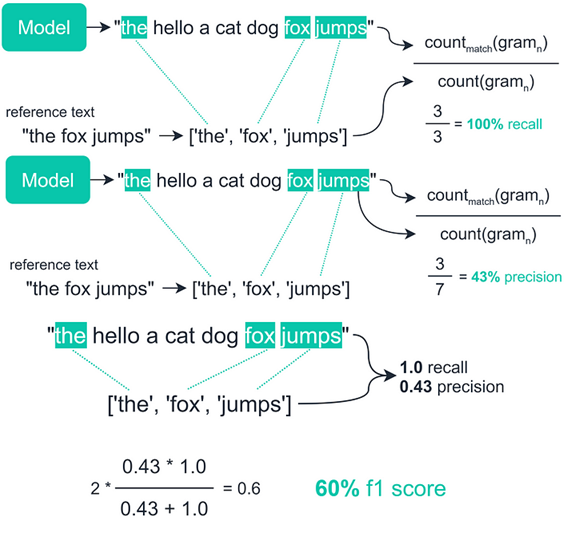

In [50]:
#@title Rouge-n
from IPython.display import Image
Image('/content/rougen.png')

In [51]:
for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

REFERENCE_SUMMARY

Bella confronts Edward about his inhuman traits—his strength, cold skin, and strange behavior.
When Bella deduces he is vampire, Edward presses her to say it. She isn’t afraid, even when he warns her she should be.
To show her the truth, he brings her into the sunlight, revealing his sparkling skin.
Instead of being horrified, Bella calls him beautiful. Edward, however, sees himself as a killer.


GPT2
TL;DR:

The two ice fluid monsters who walk into his mind are not real. They are a holographic construct created by a scientist

who specializes in cold technology.

BELLA

But he knows, right? There are no ice floes. He feels a sensation. But she is alone.

(She walks over to him again)


Sakura stares up. She thinks he must see something in her,

but she is mistaken. She is also

T5
edward mcdonald's new book, "the cold one," is out now . the book tells the story of a young vampire named bella . she's a vampire, but he's also a cold one . bella is a vampire, and he’s

In [52]:
#@title Evaluando summaries con ROUGE
rouge = load_metric("rouge")
records = []
rouge_names = ["rouge1", "rouge2"]
for model_name in summaries:
  rouge.add(prediction=summaries[model_name], reference=summaries['reference_summary'])
  score = rouge.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
  records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

<ipython-input-52-4819cf464c09>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


,rouge1,rouge2
reference_summary,1.000000,1.000000
gpt2,0.215827,0.000000
t5,0.285714,0.000000
bart,0.300000,0.016949
pegasus,0.316456,0.025641


### <font color='#EC91CE'>**Automatic Speech Recognition 🗣**</font>


In [54]:
def transcribe(audio_filepath,prompt: str) -> str:
    model = whisper.load_model("small") #'tiny', 'base', 'small', 'medium', 'large'
    result = model.transcribe(audio_filepath, initial_prompt=prompt)
    return result

result=transcribe(r"/content/audio_test.wav", prompt="")
print(result['text'])

100%|███████████████████████████████████████| 461M/461M [00:16<00:00, 29.7MiB/s]


 ¿Sabes qué caravanas y no le gusta el motil a un pa y la no lo mire? Yo me siento bien con el asilo, no me mantengo pendiente de que ira, desde que reseguen que ruede el mundo a mi alrededor listo. Nada, Sara, palcero, critiquen lo que quieran, que a mí no me importo en él.


In [56]:
#@title incluye timestamps de segmentos
for i, segment in enumerate(result["segments"]):
    start = segment["start"]
    end = segment["end"]
    text = segment["text"]
    print(f"Segmento {i} [{start} - {end}]: {text}")

Segmento 0 [0.0 - 8.16]:  ¿Sabes qué caravanas y no le gusta el motil a un pa y la no lo mire? Yo me siento bien con el asilo,
Segmento 1 [8.16 - 13.88]:  no me mantengo pendiente de que ira, desde que reseguen que ruede el mundo a mi alrededor listo.
Segmento 2 [13.88 - 19.12]:  Nada, Sara, palcero, critiquen lo que quieran, que a mí no me importo en él.


In [ ]:
#@title Usando prompts para mejorar la transcripción
result=transcribe(r"/content/audio_test.wav", ="si no le gusta, motilado, paila, así, dirá, esté bien, parcero")
print(result['text'])

In [ ]:
#@title Traducción con whisper
def transcribe(audio_filepath) -> str:
    model = whisper.load_model("small") #'tiny', 'base', 'small', 'medium', 'large'
    result = model.transcribe(audio_filepath, task='None') #task!
    return result

result=transcribe(r"/content/audio_test.wav") #lo traduce al inglés
print(result['text'])

In [ ]:
language = 'en'
speaker = 'lj_16khz'
device = torch.device('cuda')
model, symbols, sample_rate, _, apply_tts = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                                                      model='silero_tts',
                                                                      language=language,
                                                                      speaker=speaker)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-models/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 136M/136M [00:08<00:00, 17.1MB/s]


In [ ]:


example_text = 'Hands On Computer Vision is a research group with the mission of training the next generation of computer vision experts through research and collaborative experiences.'

audio = apply_tts(texts=[example_text],
                  model=model,
                  sample_rate=sample_rate,
                  symbols=symbols,
                  device=device)

display(Audio(audio[0], rate=sample_rate))

/root/.cache/torch/hub/snakers4_silero-models_master/src/silero/tts_utils.py:27: UserWarning: Text string is longer than 140 symbols.
  warnings.warn('Text string is longer than 140 symbols.')
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  return forward_call(*args, **kwargs)
